# Initial Analysis

## Connecting to SQL Lite DB
Processed data from LUMC is stored in SQL Lite DB. Raw data has been aggregated to the level of gene. For each outcome, they take the average of the percentage frequency across all sgRNAs. 

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [4]:
import sqlite3
from src.config import get_db_file, get_hussmann_supplementary_xlsx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
con = sqlite3.connect(get_db_file(use_custom=False))
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('countTable',), ('geneAlt',), ('barcodeAlt',), ('barcodecount',), ('outcomes',), ('topoutcomes',), ('outcomesGene',), ('topoutcomesGene',)]


The table 'outcomes' includes the repair outcome profiles aggregated by sample, gene, barcode, and outcome. For each outcome, we have the fraction of reads in which this outcome participated as part of the whole. We select the data from the sample 01.

In [5]:
cursor.execute("PRAGMA table_info(outcomes)")
print([c[1] for c in cursor.fetchall()])

['Barcode', 'Gene', 'Alias', 'outcomeTop', 'fraction', 'countEvents', 'mutEvents', 'trials', 'counts', 'mean', 'Pvalue']


- Barcode: sgRNA
- Gene: Gene
- Alias: Sample
- outcomeTop: top 20 outcome
- fraction: outcome count / total count for all non-WT outcomes (with WT fraction included, this becomes > 1)
- countEvents: number of reads for this barcode
- mutEvents: number of mutated reads for this barcode

In [22]:
df = pd.read_sql_query('select Barcode, Gene, Alias, outcomeTop, fraction, counts from outcomes where Alias is "MB01"', con)
df_idx = df.set_index(["Alias", "Gene", "Barcode", "outcomeTop"])
df_idx.head(10)

fraction  counts
Alias Gene          Barcode         outcomeTop                                
MB01  0610009B22Rik 0610009B22Rik-1 DELETION|0|1|1bp          0.068091   153.0
                                    DELETION|0|6|0bp          0.026702    59.0
                                    DELETION|-6|6|2bp         0.001780     4.0
                                    INSERTION_1bp|1|1|A       0.056075   126.0
                                    LARGE_DELETION|-10|5|3bp  0.017802    40.0
                                    HDR|-34|1|11              0.242101   544.0
                                    INSERTION_1bp|0|0|G       0.010236    22.0
                                    PQ_DELETION|-1|5|3bp      0.056965   128.0
                                    PQ_DELETION|-4|7|4bp      0.097908   220.0
                                    PQ_DELETION|0|3|2bp       0.080552   181.0

From the 'outcomes' table, we produce a normalised repair outcome frequency distribution per barcode, per gene

In [23]:
totals = df_idx[["counts"]].sum(level="Barcode")
df_idx_norm = df_idx[["counts"]].div(totals, level="Barcode")
df_idx_norm.head(10)

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_17723/972510684.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx[["counts"]].sum(level="Barcode")


counts
Alias Gene          Barcode         outcomeTop                        
MB01  0610009B22Rik 0610009B22Rik-1 DELETION|0|1|1bp          0.030903
                                    DELETION|0|6|0bp          0.011917
                                    DELETION|-6|6|2bp         0.000808
                                    INSERTION_1bp|1|1|A       0.025449
                                    LARGE_DELETION|-10|5|3bp  0.008079
                                    HDR|-34|1|11              0.109877
                                    INSERTION_1bp|0|0|G       0.004444
                                    PQ_DELETION|-1|5|3bp      0.025853
                                    PQ_DELETION|-4|7|4bp      0.044435
                                    PQ_DELETION|0|3|2bp       0.036558

We need to pivot this table such that we have barcodes on the vertical axis and outcomes along the columns

In [24]:
df_outcome_profiles = df_idx_norm.reset_index().pivot(index=["Gene", "Barcode"], columns="outcomeTop", values="counts").fillna(0).T
df_outcome_profiles.head()

Gene                 0610009B22Rik                                  \
Barcode            0610009B22Rik-1 0610009B22Rik-2 0610009B22Rik-3   
outcomeTop                                                           
DELETION|-10|2|1bp        0.004444        0.002385        0.003725   
DELETION|-11|2|3bp        0.005453        0.014648        0.016099   
DELETION|-1|6|2bp         0.008483        0.005280        0.009580   
DELETION|-2|2|2bp         0.004444        0.003236        0.011974   
DELETION|-3|0|1bp         0.002424        0.003066        0.002262   

Gene                                                 0610010K14Rik  \
Barcode            0610009B22Rik-4 0610009B22Rik-5 0610010K14Rik-1   
outcomeTop                                                           
DELETION|-10|2|1bp        0.002398        0.005538        0.003313   
DELETION|-11|2|3bp        0.008604        0.006027        0.011145   
DELETION|-1|6|2bp         0.007616        0.004724        0.002108   
DELETION|-2|2|2bp         0.012412        0.008796        0.008735   
DELETION|-3|0|1bp         0.000423        0.004235        0.005120   

Gene                                                                \
Barcode            0610010K14Rik-2 0610010K14Rik-3 0610010K14Rik-4   
outcomeTop                                                           
DELETION|-10|2|1bp        0.003148        0.007728        0.000000   
DELETION|-11|2|3bp        0.011102        0.006182        0.006076   
DELETION|-1|6|2bp         0.000994        0.000000        0.003920   
DELETION|-2|2|2bp         0.010771        0.024730        0.010780   
DELETION|-3|0|1bp         0.005302        0.019320        0.001960   

Gene                                ...   ccdc198                      \
Barcode            0610010K14Rik-5  ... ccdc198-1 ccdc198-2 ccdc198-3   
outcomeTop                          ...                                 
DELETION|-10|2|1bp        0.006022  ...  0.013564  0.003652  0.008430   
DELETION|-11|2|3bp        0.008387  ...  0.012121  0.005056  0.007781   
DELETION|-1|6|2bp         0.012903  ...  0.007504  0.001124  0.006095   
DELETION|-2|2|2bp         0.008172  ...  0.008947  0.019382  0.013098   
DELETION|-3|0|1bp         0.005806  ...  0.011833  0.003371  0.007003   

Gene                                      mei-04                      \
Barcode            ccdc198-4 ccdc198-5    Mei4-1    Mei4-2    Mei4-3   
outcomeTop                                                             
DELETION|-10|2|1bp  0.001218  0.005110  0.002951  0.008039  0.004950   
DELETION|-11|2|3bp  0.008222  0.009199  0.007717  0.005187  0.012311   
DELETION|-1|6|2bp   0.009744  0.007768  0.007263  0.005187  0.002158   
DELETION|-2|2|2bp   0.014312  0.016966  0.017703  0.009595  0.018530   
DELETION|-3|0|1bp   0.004263  0.001635  0.007944  0.000778  0.004061   

Gene                                    
Barcode               Mei4-4    Mei4-5  
outcomeTop                              
DELETION|-10|2|1bp  0.000000  0.023187  
DELETION|-11|2|3bp  0.003722  0.016052  
DELETION|-1|6|2bp   0.008685  0.000000  
DELETION|-2|2|2bp   0.001241  0.004162  
DELETION|-3|0|1bp   0.000000  0.010107  

[5 rows x 86569 columns]

In [25]:
df_outcome_profiles.shape

(20, 86569)

#### Questions 

**Q: Why are there only 20 outcomes? Should there be more? What filtering is happening on outcomes to get to this point?**

A: There is some filtering happening before we get to the 20 outcomes as seen in the filtered tables. It seems that each table is filtered to only have 20 outcomes available. We need to edit this to not be so arbitrarily filtered to the top 20 outcomes. 

What we now do:
 - Filter out barcode with less than 200 mutated reads
 - Filter out SNV events (according to Marco this is not interesting for now)
 - Filter out HDR events with one mismatch
 - Do not transform TANDEMDUPLICATION and TANDEMDUPLICATION_COMPOUND into DELINS event, but this could be done as TD and TDC events may be rare




**Q: What does the barcode stand for? Assuming its for the guide RNA per gene.**

A: Yes, it is the knockout sgRNA

**Q: Did we use HDR at any point? Were donor sequences supplied to the cells as part of the experiements?**

A: Donor sequences were supplied to the cells so that HDR events could be detected

**Q: For TINS, DELINS, HDR, and HDR1MM, why does the data contain -1 for the homologyLength value?**

A: -1 probably means that this field is not applicable in these cases. (Can double check with Robin.)

**Q: What do each of the points mean?**

A:
DELETION | delRelativeStart | delRelativeEnd | homologylength 
INSERTION | delRelativeStart | delRelativeEnd | insertion

But in our current custom db, we write it out as the following:

ANY DELETION | delRelativeStart | delRelativeEnd | homologylength | insertion 


**Q: There are genes which are described as "non-targetting". Are they not the controls that we are interested in?**

A: There are some gens that are lethal. Every gene has 5 barcodes. Some barcodes had no reads. Others did. Assuming that the barcodes that had no reads were lethal, we assumed that the barcodes that had reads were not targetting the "lehtal" genes correctly and could be used as non-targetting controls. This works well in many cases, but there were enough cases that this was not true as to mean that this approach should not be used.

**Q: What are the PQ_DELETIONS and so on as seen in the SQLite DB tables?**

A: Arbitrary at the moment. These are deletions whose frequency are heavily impacted by knockout of POLQ. 


## Compare impact of two knockouts on the repair outcome profile



First, we will compare the repair outcomes in sample 01 for two gene knockouts: POLQ and Trp53bp1.

In [26]:
df_outcome_profiles

Gene                       0610009B22Rik                                  \
Barcode                  0610009B22Rik-1 0610009B22Rik-2 0610009B22Rik-3   
outcomeTop                                                                 
DELETION|-10|2|1bp              0.004444        0.002385        0.003725   
DELETION|-11|2|3bp              0.005453        0.014648        0.016099   
DELETION|-1|6|2bp               0.008483        0.005280        0.009580   
DELETION|-2|2|2bp               0.004444        0.003236        0.011974   
DELETION|-3|0|1bp               0.002424        0.003066        0.002262   
DELETION|-6|6|2bp               0.000808        0.002725        0.006519   
DELETION|0|1|1bp                0.030903        0.039687        0.028872   
DELETION|0|6|0bp                0.011917        0.016181        0.012374   
HDR|-34|1|11                    0.109877        0.087379        0.085684   
INSERTION_1bp|0|0|G             0.004444        0.001363        0.005056   
INSERTION_1bp|1|1|A             0.025449        0.029297        0.025412   
LARGE_DELETION|-10|5|3bp        0.008079        0.001874        0.005721   
LARGE_DELETION|-10|6|2bp        0.002424        0.002725        0.002927   
LARGE_DELETION|-14|8|2bp        0.002828        0.004258        0.000000   
LARGE_DELETION|-8|8|1bp         0.000000        0.001703        0.000000   
PQ_DELETION|-1|5|3bp            0.025853        0.034917        0.042044   
PQ_DELETION|-4|7|4bp            0.044435        0.050928        0.064795   
PQ_DELETION|0|3|2bp             0.036558        0.033725        0.049361   
TINS                            0.004646        0.014648        0.009846   
WT|0|0|0                        0.666532        0.649974        0.617749   

Gene                                                       0610010K14Rik  \
Barcode                  0610009B22Rik-4 0610009B22Rik-5 0610010K14Rik-1   
outcomeTop                                                                 
DELETION|-10|2|1bp              0.002398        0.005538        0.003313   
DELETION|-11|2|3bp              0.008604        0.006027        0.011145   
DELETION|-1|6|2bp               0.007616        0.004724        0.002108   
DELETION|-2|2|2bp               0.012412        0.008796        0.008735   
DELETION|-3|0|1bp               0.000423        0.004235        0.005120   
DELETION|-6|6|2bp               0.005642        0.001303        0.006024   
DELETION|0|1|1bp                0.027080        0.030298        0.042319   
DELETION|0|6|0bp                0.007757        0.015475        0.022741   
HDR|-34|1|11                    0.100000        0.069230        0.085542   
INSERTION_1bp|0|0|G             0.003808        0.000977        0.001205   
INSERTION_1bp|1|1|A             0.039492        0.037302        0.024398   
LARGE_DELETION|-10|5|3bp        0.006770        0.008308        0.002108   
LARGE_DELETION|-10|6|2bp        0.003808        0.000814        0.007229   
LARGE_DELETION|-14|8|2bp        0.000423        0.000489        0.002560   
LARGE_DELETION|-8|8|1bp         0.001410        0.000000        0.004669   
PQ_DELETION|-1|5|3bp            0.035402        0.027529        0.026355   
PQ_DELETION|-4|7|4bp            0.067701        0.059293        0.053163   
PQ_DELETION|0|3|2bp             0.052327        0.039909        0.045030   
TINS                            0.005360        0.011565        0.012651   
WT|0|0|0                        0.611566        0.668187        0.633584   

Gene                                                                      \
Barcode                  0610010K14Rik-2 0610010K14Rik-3 0610010K14Rik-4   
outcomeTop                                                                 
DELETION|-10|2|1bp              0.003148        0.007728        0.000000   
DELETION|-11|2|3bp              0.011102        0.006182        0.006076   
DELETION|-1|6|2bp               0.000994        0.000000        0.003920   
DELETION|-2|2|2bp               0.010771      

In [27]:
POLQ = "polq"
TRP53BP1 = "trp53bp1"

cols_to_compare = list(filter(lambda x: POLQ in x[0].lower() or TRP53BP1 in x[0].lower(), df_outcome_profiles.columns))
df_outcomes_to_compare = df_outcome_profiles[cols_to_compare]
df_outcomes_to_compare

Gene                          Polq                                          \
Barcode                     Polq-1    Polq-2    Polq-3    Polq-4    Polq-5   
outcomeTop                                                                   
DELETION|-10|2|1bp        0.000000  0.005799  0.004235  0.006401  0.000000   
DELETION|-11|2|3bp        0.010204  0.016108  0.008257  0.019915  0.015899   
DELETION|-1|6|2bp         0.000000  0.000000  0.002117  0.000000  0.001645   
DELETION|-2|2|2bp         0.008503  0.001933  0.004235  0.012802  0.002467   
DELETION|-3|0|1bp         0.000000  0.000000  0.000423  0.007112  0.000822   
DELETION|-6|6|2bp         0.000000  0.000000  0.000212  0.004979  0.000000   
DELETION|0|1|1bp          0.015873  0.032216  0.025408  0.056188  0.015351   
DELETION|0|6|0bp          0.006803  0.006443  0.004658  0.010669  0.003564   
HDR|-34|1|11              0.051020  0.060567  0.066695  0.042674  0.064693   
INSERTION_1bp|0|0|G       0.000000  0.003866  0.004235  0.000000  0.003015   
INSERTION_1bp|1|1|A       0.016440  0.010954  0.029642  0.015647  0.018640   
LARGE_DELETION|-10|5|3bp  0.000000  0.000000  0.004235  0.007112  0.004660   
LARGE_DELETION|-10|6|2bp  0.012472  0.001933  0.011645  0.002134  0.001919   
LARGE_DELETION|-14|8|2bp  0.002834  0.004510  0.001482  0.010669  0.001645   
LARGE_DELETION|-8|8|1bp   0.000000  0.001933  0.000000  0.000000  0.001919   
PQ_DELETION|-1|5|3bp      0.005102  0.010309  0.007834  0.057610  0.003289   
PQ_DELETION|-4|7|4bp      0.009070  0.010954  0.030913  0.075391  0.007950   
PQ_DELETION|0|3|2bp       0.022676  0.013531  0.017150  0.057610  0.014254   
TINS                      0.004535  0.001289  0.000212  0.009957  0.006579   
WT|0|0|0                  0.834467  0.817655  0.776413  0.603129  0.831689   

Gene                       Trp53bp1                                   \
Barcode                  Trp53bp1-1 Trp53bp1-2 Trp53bp1-3 Trp53bp1-4   
outcomeTop                                                             
DELETION|-10|2|1bp         0.007204   0.001702   0.001866   0.000000   
DELETION|-11|2|3bp         0.008544   0.007709   0.016621   0.006325   
DELETION|-1|6|2bp          0.005026   0.007309   0.006275   0.010541   
DELETION|-2|2|2bp          0.004188   0.010012   0.014925   0.004216   
DELETION|-3|0|1bp          0.005864   0.003905   0.006275   0.006325   
DELETION|-6|6|2bp          0.006534   0.001702   0.001018   0.000000   
DELETION|0|1|1bp           0.008209   0.018422   0.027476   0.035840   
DELETION|0|6|0bp           0.019434   0.016920   0.015265   0.016866   
HDR|-34|1|11               0.115597   0.137966   0.135007   0.151792   
INSERTION_1bp|0|0|G        0.000000   0.007109   0.006784   0.000000   
INSERTION_1bp|1|1|A        0.018261   0.033540   0.014925   0.030218   
LARGE_DELETION|-10|5|3bp   0.003183   0.003905   0.010516   0.000000   
LARGE_DELETION|-10|6|2bp   0.001173   0.001902   0.003053   0.000703   
LARGE_DELETION|-14|8|2bp   0.000000   0.000901   0.000170   0.000000   
LARGE_DELETION|-8|8|1bp    0.001005   0.000801   0.002374   0.000000   
PQ_DELETION|-1|5|3bp       0.018429   0.024930   0.026628   0.018974   
PQ_DELETION|-4|7|4bp       0.049757   0.063877   0.090061   0.052706   
PQ_DELETION|0|3|2bp        0.034344   0.039047   0.036974   0.052706   
TINS                       0.002010   0.009011   0.010855   0.005622   
WT|0|0|0                   0.691238   0.609331   0.572931   0.607168   

Gene                                 
Barcode                  Trp53bp1-5  
outcomeTop                           
DELETION|-10|2|1bp         0.006833  
DELETION|-11|2|3bp         0.000661  
DELETION|-1|6|2bp          0.002645  
DELETION|-2|2|2bp          0.007494  
DELETION|-3|0|1bp          0.007714  
DELETION|-6|6|2bp          0.002425  
DELETION|0|1|1bp           0.008816  
DELETION|0|6|0bp           0.010359  
HDR|-34|1|11               0.129601  
INSERTION_1bp|0|0|G        0.000000  
INSERTION_1bp|1|1|A        0.019616  
LARGE_DELETION|-

Index(['outcomeTop', 'Barcode', 'Frequency', 'Gene'], dtype='object')


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_17723/3937490705.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='both', alpha=.75)


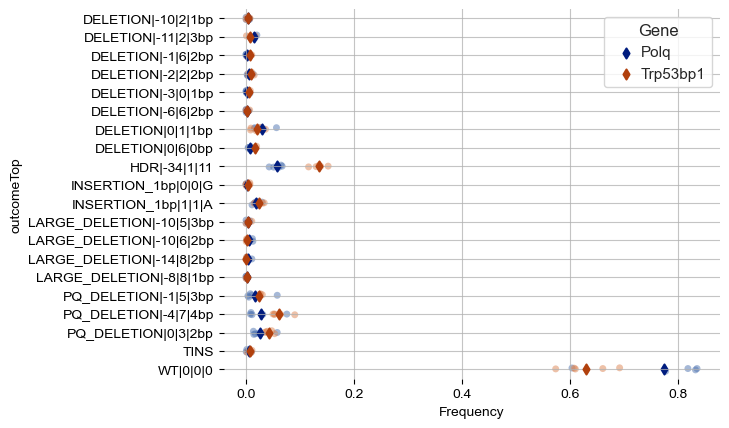

In [28]:

df_scatterplot = df_outcomes_to_compare.droplevel(axis=1, level=0).reset_index().melt(id_vars=["outcomeTop"], value_vars=[c[1] for c in cols_to_compare], value_name="Frequency")
df_scatterplot["Gene"] = df_scatterplot["Barcode"].apply(lambda x: x[:-2])
print(df_scatterplot.columns)

# Initialize the figure
f, ax = plt.subplots()
sns.set_theme(style="whitegrid")
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(data=df_scatterplot, y="outcomeTop", x="Frequency", hue="Gene", dodge=False, alpha=.5, zorder=1)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
g = sns.pointplot(data=df_scatterplot, y="outcomeTop", x="Frequency", hue="Gene", #dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=.75, ci=None, linestyles="--")

# Improve the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title="Gene",
          handletextpad=0, columnspacing=1,
          loc="upper right", ncol=1, frameon=True)
ax.grid(b=True, which='both', alpha=.75)

<AxesSubplot:xlabel='Gene-Barcode', ylabel='outcomeTop'>

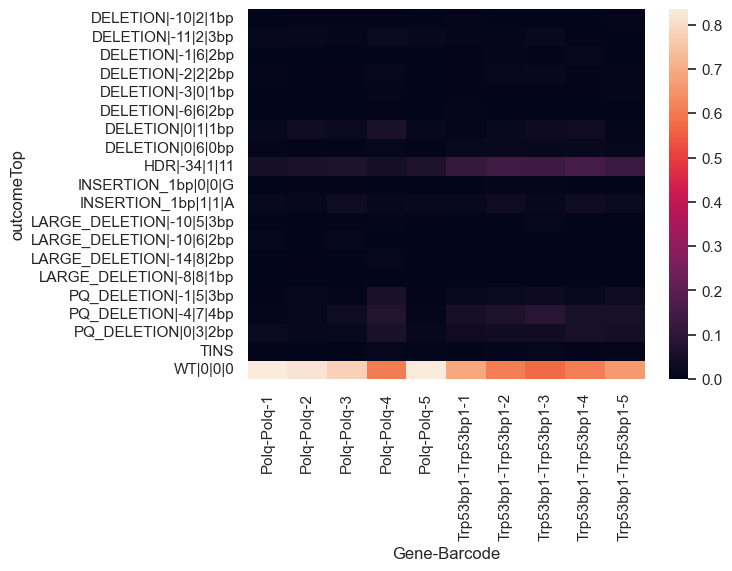

In [29]:
sns.heatmap(df_outcomes_to_compare)

From the above data, we can see that PQ_Deletions (need to get the proper definition from Robin about what these events are) are less frequent in POLQ deficient cells, and that WT outcomes are more common in Polq deficient cells. This shows us that the data does contain information regarding a genes impact on the repair outcome profile.

Of greater interest, we note in the heatmap that Polq-4 doesn't seem to impact WT outcome frequency to the same extent as the other sgRNAs. This may be an argument for keeping each sgRNA seperate and not aggregating all sgRNAs as LUMC are currently doing it. Maybe having multiple sgRNAs would provide a richer dataset?

We can try this experimentally by aggregating the barcodes to the gene level, and redoing the above analysis.

In [30]:
df_outcomes_to_compare_mean = df_outcomes_to_compare.groupby(level="Gene", axis=1).mean()
df_outcomes_to_compare_mean.head()

Gene,Polq,Trp53bp1
outcomeTop,,
DELETION|-10|2|1bp,0.003287,0.003521
DELETION|-11|2|3bp,0.014077,0.007972
DELETION|-1|6|2bp,0.000752,0.006359
DELETION|-2|2|2bp,0.005988,0.008167
DELETION|-3|0|1bp,0.001672,0.006017


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_17723/3288356702.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='both', alpha=.75)


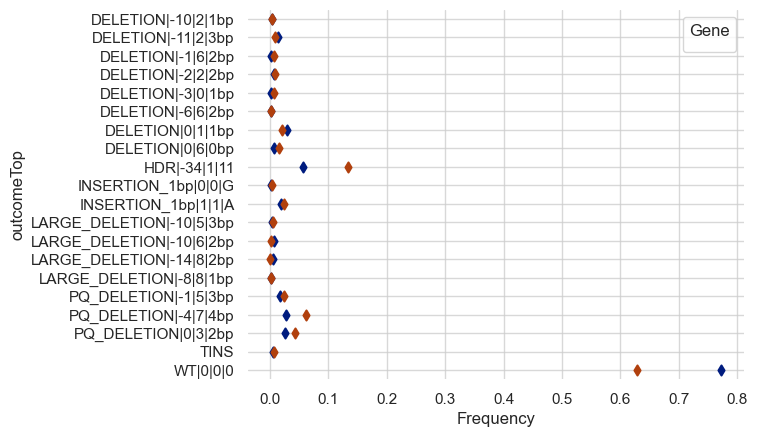

In [31]:
df_scatterplot = df_outcomes_to_compare_mean.reset_index().melt(id_vars=["outcomeTop"], value_vars=["Polq", "Trp53bp1"], value_name="Frequency")

# Initialize the figure
f, ax = plt.subplots()
sns.set_theme(style="whitegrid")
sns.despine(bottom=True, left=True)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
g = sns.pointplot(data=df_scatterplot, y="outcomeTop", x="Frequency", hue="Gene", 
              join=False, palette="dark",
              markers="d", scale=.75, ci=None, linestyles="--")

# Improve the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title="Gene",
          handletextpad=0, columnspacing=1,
          loc="upper right", ncol=1, frameon=True)
ax.grid(b=True, which='both', alpha=.75)

<AxesSubplot:xlabel='Gene', ylabel='outcomeTop'>

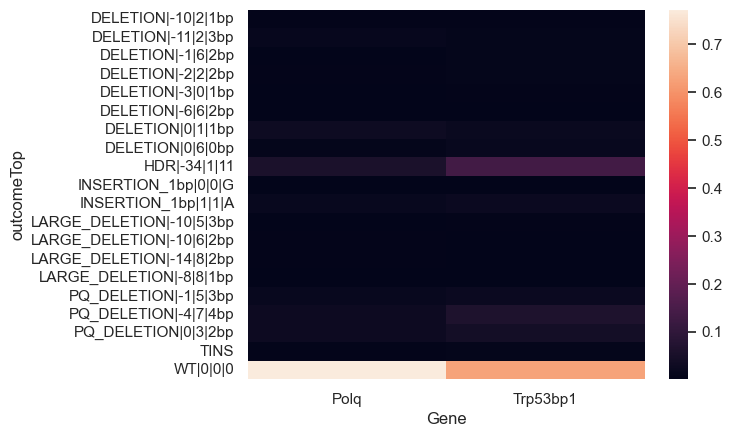

In [32]:
sns.heatmap(df_outcomes_to_compare_mean.groupby(level="Gene", axis=1).mean())

## Seeking the source of variation

From the above data, we can see that the knockouts do affect the repair outcome profiles. What we cannot say yet is how much, and in what direction, these profiles deviate from the "normal" repair outcome profile. To do so is tricky, because we do not have any controls as part of this experiment. We have two options:
 - Take the average across all sgRNAs, and characterise the log fold change from the "average" profile
 - Compare all repair outcome profiles to each other using some distance/dissimilarity metric. Profiles with a greater deviation to the "average" profile will have a higher overall distance and can be further seperated from the "pack". We can then draw a threshold and assume that everything below the threshold has no impact on the repair outcome profiles.


### Calculating pairwise distance
Let's use Pearson's Correlation for now

In [33]:
df_outcome_profiles_mean = df_outcome_profiles.groupby(level="Gene", axis=1).mean()

In [34]:
df_outcome_profiles_mean.shape

(20, 18363)

In [35]:
df_outcome_profiles_mean_corr = df_outcome_profiles_mean.corr()
df_outcome_profiles_mean_corr.head()

Gene,0610009B22Rik,0610010K14Rik,0610030E20Rik,0610040J01Rik,1110004F10Rik,1110017D15Rik,1110032A03Rik,1110032F04Rik,1110059E24Rik,1110059G10Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,ccdc198,mei-04
Gene,,,,,,,,,,,,,,,,,,,,,
0610009B22Rik,1.000000,0.999629,0.998523,0.998262,0.999344,0.999125,0.999192,0.999764,0.998039,0.997706,...,0.999590,0.999541,0.999489,0.999449,0.999598,0.999680,0.999535,0.998473,0.999687,0.999006
0610010K14Rik,0.999629,1.000000,0.999292,0.999316,0.998651,0.999755,0.999581,0.999579,0.999027,0.998938,...,0.999808,0.999926,0.999608,0.999181,0.999039,0.999197,0.999209,0.999315,0.999068,0.998813
0610030E20Rik,0.998523,0.999292,1.000000,0.999279,0.997162,0.999238,0.998621,0.998761,0.998667,0.998643,...,0.999364,0.999428,0.998952,0.998222,0.997271,0.998204,0.997681,0.999489,0.997984,0.998227
0610040J01Rik,0.998262,0.999316,0.999279,1.000000,0.996885,0.999114,0.998449,0.998142,0.999373,0.999276,...,0.999375,0.999492,0.999018,0.997765,0.997236,0.997847,0.997571,0.998927,0.997422,0.997996
1110004F10Rik,0.999344,0.998651,0.997162,0.996885,1.000000,0.997915,0.998163,0.999346,0.996415,0.995688,...,0.998621,0.998526,0.999108,0.999602,0.999499,0.999712,0.999150,0.996735,0.999394,0.998946


In [36]:
df_similarity = df_outcome_profiles_mean_corr.sum().sort_values()
df_similarity

Gene
Trp53       16280.375332
Ugt2b38     17207.414240
Gm7361      17273.191501
Vmn1r128    17486.123228
Obp1a       17571.114941
                ...     
Rap2b       18345.963345
Plce1       18345.971849
Limd2       18346.004064
Tjap1       18346.017852
Foxa2       18346.176393
Length: 18363, dtype: float64

<AxesSubplot:ylabel='Count'>

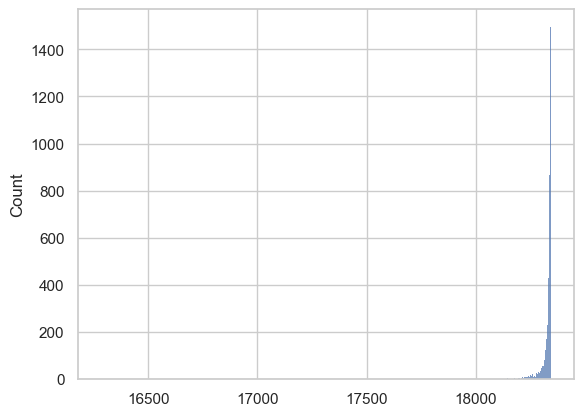

In [37]:
sns.histplot(df_similarity)

The genes are now ranked in terms of their similarity to all other gene profiles. The more a profile "stands out", the most different that gene is relative to all other repair outcome profile. The assumption here is that most genes will not have big impact on the repair outcome profile, therefore, most genes should have high correlations with one another and thus group together when we sum up their correlations with one another.

We could possibly use this similarity metric as a ranking for how likely genes are to be involved in DNA repair

In [38]:
most_similar = df_similarity[-100:]
most_similar

Gene
Prkar1b          18345.462299
Ndufaf7          18345.463410
Slco2b1          18345.465449
Slc66a2          18345.466642
Non-targeting    18345.468042
                     ...     
Rap2b            18345.963345
Plce1            18345.971849
Limd2            18346.004064
Tjap1            18346.017852
Foxa2            18346.176393
Length: 100, dtype: float64

In [39]:
least_similar = df_similarity[:1000]
least_similar

Gene
Trp53       16280.375332
Ugt2b38     17207.414240
Gm7361      17273.191501
Vmn1r128    17486.123228
Obp1a       17571.114941
                ...     
Fbxo5       18287.949937
Wdr46       18287.961991
Snap23      18287.963046
Zfp300      18287.967294
Dram1       18287.967501
Length: 1000, dtype: float64

### Getting repair genes from Hussmann et al 2021

We now have a list of the top 100 most "dissimilar" gene repair outcome profiles when compared to all other profiles. This could be indicative of the most "active" genes in the entire dataset. We can compare these genes to those in the select hussmann dataset, as these genes are known to be involved in DNA repair. Will need to take care of formatting, etc... 

In [40]:
hussmann_repair_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)["Gene"].str.lower()
hussmann_repair_genes.head()

0    actl6a
1     actr5
2     actr8
3     aicda
4    alkbh2
Name: Gene, dtype: object

To be continued on Monday 22nd...

### Principle Component Analysis

We can do principle component analysis to reduce the dimensionality across the repair outcomes to help identify the repair outcomes which result in the best seperation of the repair outcome profiles

In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Convert the matrix to gene x outcomes
df_outcome_profiles_mean_T = df_outcome_profiles_mean.T
df_outcome_profiles_mean_T.head()

outcomeTop,DELETION|-10|2|1bp,DELETION|-11|2|3bp,DELETION|-1|6|2bp,DELETION|-2|2|2bp,DELETION|-3|0|1bp,DELETION|-6|6|2bp,DELETION|0|1|1bp,DELETION|0|6|0bp,HDR|-34|1|11,INSERTION_1bp|0|0|G,INSERTION_1bp|1|1|A,LARGE_DELETION|-10|5|3bp,LARGE_DELETION|-10|6|2bp,LARGE_DELETION|-14|8|2bp,LARGE_DELETION|-8|8|1bp,PQ_DELETION|-1|5|3bp,PQ_DELETION|-4|7|4bp,PQ_DELETION|0|3|2bp,TINS,WT|0|0|0
Gene,,,,,,,,,,,,,,,,,,,,
0610009B22Rik,0.003698,0.010166,0.007137,0.008172,0.002482,0.003399,0.031368,0.012741,0.090434,0.003130,0.031391,0.006150,0.002540,0.001600,0.000623,0.033149,0.057431,0.042376,0.009213,0.642802
0610010K14Rik,0.003724,0.008592,0.004425,0.009742,0.005855,0.003653,0.026748,0.013273,0.080206,0.002567,0.025709,0.004929,0.004153,0.003801,0.002803,0.027609,0.055496,0.042257,0.007821,0.666635
0610030E20Rik,0.004363,0.010095,0.003924,0.011591,0.003282,0.002834,0.028069,0.023130,0.063174,0.003312,0.027387,0.001945,0.001787,0.003209,0.001186,0.027194,0.067347,0.038609,0.006790,0.670772
0610040J01Rik,0.004370,0.006552,0.001526,0.014561,0.004082,0.004065,0.022263,0.009581,0.062799,0.004071,0.027124,0.005093,0.001454,0.002329,0.002620,0.020388,0.056749,0.052622,0.004341,0.693409
1110004F10Rik,0.001360,0.006421,0.006910,0.010970,0.006125,0.002323,0.024830,0.012533,0.102665,0.000765,0.033685,0.006263,0.003389,0.001633,0.001873,0.025643,0.067071,0.044195,0.014597,0.626749


In [80]:
# fit the PCA model
pca_out = PCA().fit(df_outcome_profiles_mean_T)

# get the component variance
# Proportion of Variance (from PC1 to PC6)
print("Component variance")
print(pca_out.explained_variance_ratio_)

# Cumulative proportion of variance 
print("Cumulative proportion of variance explained")
cum_variance = np.cumsum(pca_out.explained_variance_ratio_)
print(np.cumsum(pca_out.explained_variance_ratio_))

df_outcome_profiles_mean_T_st =  StandardScaler().fit_transform(df_outcome_profiles_mean_T)  
pd.DataFrame(df_outcome_profiles_mean_T_st, columns=df_outcome_profiles_mean_T.columns).head(2)

Component variance
[9.10869591e-01 3.01049791e-02 1.39082335e-02 9.37340589e-03
 7.41398858e-03 6.98351457e-03 4.46674943e-03 3.31694212e-03
 2.51219117e-03 2.20396048e-03 1.55748018e-03 1.23374970e-03
 1.18352310e-03 1.07030352e-03 9.49200132e-04 8.88226742e-04
 8.29964330e-04 5.91619867e-04 5.42376694e-04 5.37510477e-29]
Cumulative proportion of variance explained
[0.91086959 0.94097457 0.9548828  0.96425621 0.9716702  0.97865371
 0.98312046 0.9864374  0.9889496  0.99115356 0.99271104 0.99394479
 0.99512831 0.99619861 0.99714781 0.99803604 0.998866   0.99945762
 1.         1.        ]


outcomeTop,DELETION|-10|2|1bp,DELETION|-11|2|3bp,DELETION|-1|6|2bp,DELETION|-2|2|2bp,DELETION|-3|0|1bp,DELETION|-6|6|2bp,DELETION|0|1|1bp,DELETION|0|6|0bp,HDR|-34|1|11,INSERTION_1bp|0|0|G,INSERTION_1bp|1|1|A,LARGE_DELETION|-10|5|3bp,LARGE_DELETION|-10|6|2bp,LARGE_DELETION|-14|8|2bp,LARGE_DELETION|-8|8|1bp,PQ_DELETION|-1|5|3bp,PQ_DELETION|-4|7|4bp,PQ_DELETION|0|3|2bp,TINS,WT|0|0|0
0,0.045907,0.628138,1.225126,-0.787139,-0.875907,0.145529,0.567595,-0.310753,0.672472,-0.008803,0.509355,0.726151,-0.356091,-0.285348,-0.963986,1.244319,0.172525,0.268052,0.461678,-0.577816
1,0.059483,0.098216,-0.059781,-0.330507,0.806482,0.290417,-0.225014,-0.180080,0.093900,-0.349030,-0.525192,0.145952,0.561882,1.357958,0.612288,0.329897,-0.001720,0.253551,-0.019325,-0.106431


In [82]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i)+"\n{:.3f}".format(cum_variance[i-1]) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_outcome_profiles_mean_T.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1\n0.911,PC2\n0.941,PC3\n0.955,PC4\n0.964,PC5\n0.972,PC6\n0.979,PC7\n0.983,PC8\n0.986,PC9\n0.989,PC10\n0.991,PC11\n0.993,PC12\n0.994,PC13\n0.995,PC14\n0.996,PC15\n0.997,PC16\n0.998,PC17\n0.999,PC18\n0.999,PC19\n1.000,PC20\n1.000
variable,,,,,,,,,,,,,,,,,,,,
DELETION|-10|2|1bp,0.010665,-0.012157,-0.006344,-0.007395,0.008150,-0.002834,0.033099,0.043857,0.042983,0.035480,0.232861,-0.065202,0.244060,0.838987,-0.307362,-0.096736,-0.091457,-0.088963,-0.037369,0.223607
DELETION|-11|2|3bp,0.021807,-0.029046,-0.024972,-0.027218,0.033453,0.010213,0.141147,0.194673,0.697585,-0.545211,-0.299741,0.037484,-0.061935,-0.020850,-0.067468,-0.017991,-0.016446,-0.052355,-0.031383,0.223607
DELETION|-1|6|2bp,0.012431,-0.018938,-0.007016,-0.017605,0.009702,0.005805,0.056751,0.043618,0.056116,0.013336,0.458335,-0.557981,-0.597038,-0.147872,-0.161069,-0.064218,-0.062045,-0.078588,-0.026892,0.223607
DELETION|-2|2|2bp,0.028529,-0.034968,-0.042308,-0.042592,0.043337,0.009317,0.221625,0.723317,-0.542696,-0.140758,-0.218726,-0.008963,-0.020336,-0.034142,-0.040848,-0.009139,-0.023231,-0.054061,-0.032289,0.223607
DELETION|-3|0|1bp,0.011313,-0.015587,-0.014068,-0.007793,0.005786,0.005087,0.034559,0.024913,0.067128,0.014583,0.285143,-0.184240,0.707214,-0.488668,-0.260045,-0.066223,-0.085576,-0.069837,-0.066099,0.223607
DELETION|-6|6|2bp,0.008794,-0.010924,-0.005493,-0.006574,0.005680,-0.003917,0.029428,0.026023,0.051288,0.033948,0.148881,-0.006857,0.060474,0.057753,0.365472,0.826220,-0.291675,-0.109440,-0.043488,0.223607
DELETION|0|1|1bp,0.060601,-0.090680,-0.185727,-0.407673,-0.452432,-0.657612,-0.219484,-0.133798,-0.090461,-0.042741,-0.134595,0.003742,-0.032092,-0.019932,-0.038663,-0.018603,-0.028132,-0.041078,-0.017405,0.223607
DELETION|0|6|0bp,0.038514,-0.053506,-0.049921,-0.044323,0.069052,0.030032,0.733200,-0.551785,-0.221555,-0.068006,-0.182069,0.012173,-0.028586,-0.013959,-0.043497,-0.013596,-0.017637,-0.046578,-0.029995,0.223607
HDR|-34|1|11,0.281495,0.890658,0.144857,0.115355,-0.032841,-0.013982,-0.116240,-0.081532,-0.067590,-0.032083,-0.106352,0.000982,-0.027443,-0.018371,-0.036311,-0.011681,-0.018205,-0.039453,-0.020535,0.223607


In [84]:
pca_scores = PCA().fit_transform(df_outcome_profiles_mean_T_st)
pca_scores_df = pd.DataFrame(pca_scores, columns=pc_list, index=df_outcome_profiles_mean_T.index)
pca_scores_df.head()

,PC1\n0.911,PC2\n0.941,PC3\n0.955,PC4\n0.964,PC5\n0.972,PC6\n0.979,PC7\n0.983,PC8\n0.986,PC9\n0.989,PC10\n0.991,PC11\n0.993,PC12\n0.994,PC13\n0.995,PC14\n0.996,PC15\n0.997,PC16\n0.998,PC17\n0.999,PC18\n0.999,PC19\n1.000,PC20\n1.000
Gene,,,,,,,,,,,,,,,,,,,,
0610009B22Rik,1.219537,0.458972,-0.120232,-0.248330,1.070276,-0.071063,-1.021385,0.032271,0.827413,-0.492751,0.049156,-0.277581,-1.149086,-0.702707,0.606131,-0.780260,0.579825,-0.078441,0.435099,2.270714e-15
0610010K14Rik,0.372286,-0.872771,0.729776,0.443096,-0.757634,0.629257,0.554755,-0.074410,0.125588,0.872848,0.287472,0.092602,-0.141223,-0.001214,0.387671,-0.295633,-0.024930,-0.195406,0.115201,-6.704910e-16
0610030E20Rik,0.334348,-0.080460,1.289685,0.631575,0.247069,-0.395331,0.452125,0.061657,0.253665,-1.408034,0.248917,-0.593741,-0.251628,1.894817,-0.561892,0.612301,0.481508,-0.007570,-1.362314,1.346217e-15
0610040J01Rik,-0.951270,0.708046,-0.110695,1.095414,0.189148,0.365882,0.518863,-0.853414,-0.999018,0.406281,0.642145,-0.111590,1.689636,0.021509,-0.403556,-0.572344,-1.514054,-1.380696,-0.671170,2.128451e-15
1110004F10Rik,1.718917,-1.213513,-0.192728,-0.217263,0.390210,-0.243720,-1.105162,1.299180,-0.119989,0.844359,-1.757308,1.438537,-0.816081,-1.070203,-0.493776,-0.865558,-0.838649,0.730281,0.052167,-4.701723e-15


<AxesSubplot:xlabel='PC1\n0.911', ylabel='PC2\n0.941'>

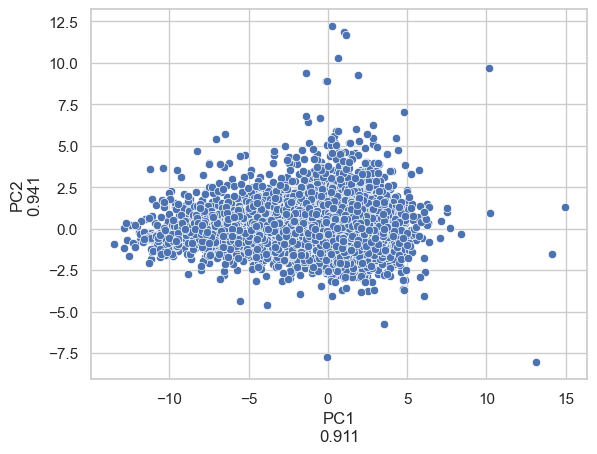

In [86]:
sns.scatterplot(data=pca_scores_df, x="PC1\n0.911", y="PC2\n0.941")

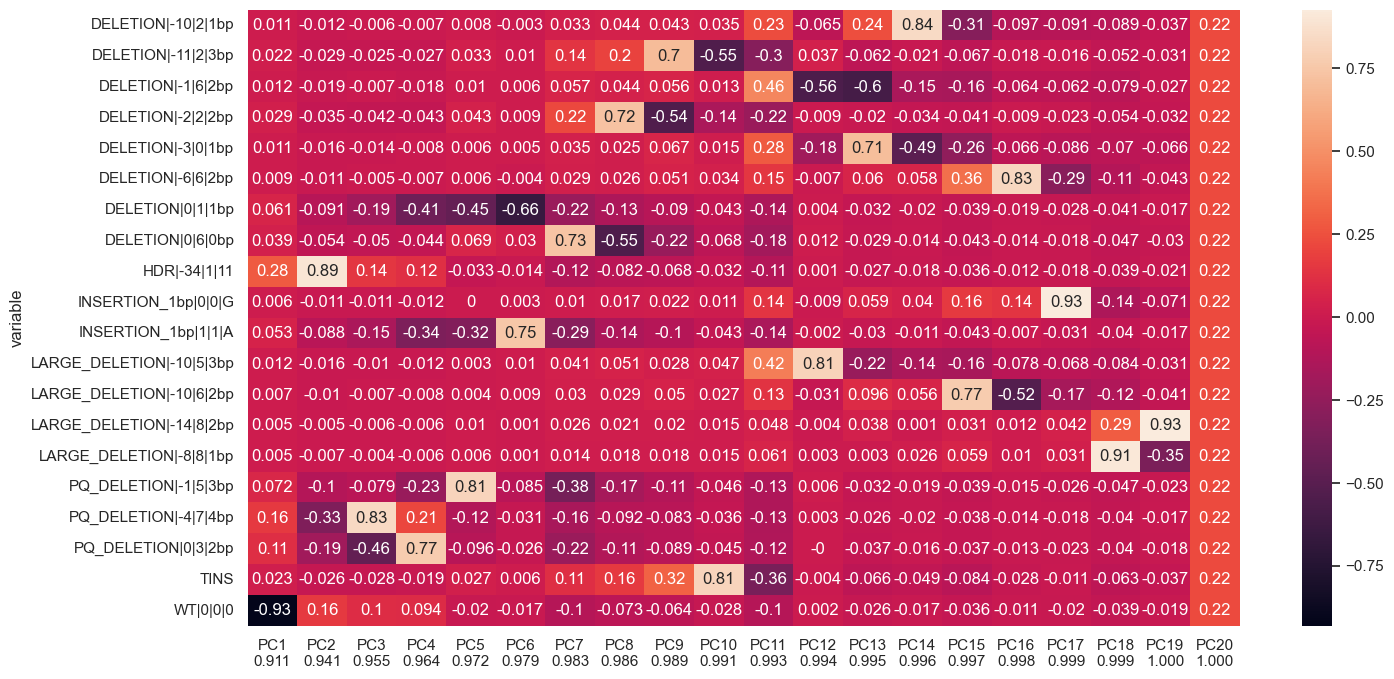

In [91]:
# get correlation matrix plot for loadings
plt.figure(figsize=(16,8))
ax = sns.heatmap(loadings_df.round(3), annot=True)
plt.show()

Most of the variance in the data among the repair outcome profiles can be explained by their influence on the proportion of WT data seen. Need to review this with Robin and see if this is interesting, or if we need to be filtering out this wild-type data and focusing exclusively on the repair outcome profiles. 

#### Questions
**Q: Could this also cause problems when using correlation as a distance metric?**
 
**Q: Does this say anything about this gene affecting the ability of the cell to repair properly? Or is this simply an artifact to be ignored? Probably caused by natural variation between cellular efficency? Maybe if I annotate known repair genes/most similar and dissimilar I might be able to get an idea. Could also plot the density of the WT frequencys across the genes. Maybe it's multimodal (indicating that different groups of genes have different effects) or unimodal (maybe normally distributed, indicating that there isn't much of interest here)**

<AxesSubplot:xlabel='WT|0|0|0', ylabel='Count'>

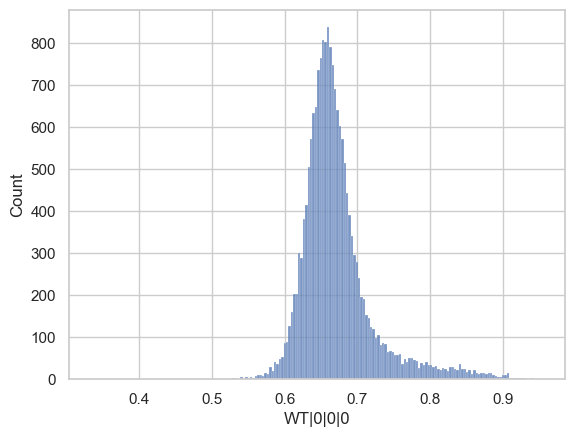

In [92]:
sns.histplot(df_outcome_profiles_mean_T["WT|0|0|0"])